#  I  made some modifications for this sample

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For Plotting
import matplotlib.pyplot as plt

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(3407)

# Args

In [2]:
class Args:
    def __init__(self) -> None:

        '''***********- model params -*************'''
        self.model_name = "hw1"

        '''***********- data path -*************'''
        self.data_path = '../../../data/hw1/'
        self.train_file='covid.train.csv'
        self.val_file = ''
        self.test_file = 'covid.test.csv'
        self.submit_file = '../../../submit/{}.csv'.format(self.model_name)

        '''***********- model path -*************'''
        self.MODEL_PATH = '../../../ckpts/{}'.format(self.model_name)
        if not os.path.exists(self.MODEL_PATH):
            os.makedirs(self.MODEL_PATH)

        '''***********- cpu or gpu and dara parallel -*************'''
        # self.gpus = [] # cpu
        # self.gpus = [0] # single gpu
        self.gpus = [0] # multi gpu
        self.WORKERS = 5 # num of workers for data loader

        '''***********- Hyper Arguments -*************'''
        self.rand_seed=40
        self.batch_size = 256
        self.lr = 1e-5
        self.epochs = 200
        self.split_ratio = 0.2
        self.momentum = 0.9
        self.patience = 20
        self.l2_lambda = 0.1

# Utils

In [3]:
def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

# Dataset

In [4]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Model

In [5]:
# baseline
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        x = self.net(x)
        x = x.squeeze(1)
        return x

# Feature selection

In [6]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        # 计算每个特征与y_train的相关系数
        correlations = np.array([np.corrcoef(raw_x_train[:, i], y_train)[0, 1] for i in range(raw_x_train.shape[1])])
        # 选择相关系数绝对值大于0.1的特征
        feat_idx = np.where(np.abs(correlations) > 0.1)[0]
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Trainer

In [7]:
def trainer():
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)
    # Print out the data size.
    print(f"""train_data size: {train_data.shape} 
          valid_data size: {valid_data.shape} 
          test_data size: {test_data.shape}""")

    print("Selecting features...")
    x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, select_all=False)
    # Print out the number of features.
    print(f'number of features: {x_train.shape[1]}')

    train_dataset, val_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                                COVID19Dataset(x_valid, y_valid), \
                                                COVID19Dataset(x_test)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    print("***********- ***********- Training begin -*************")
    train_epochs_loss = []
    # train_epochs_mse = []
    valid_epochs_loss = []
    # valid_epochs_mse = []
    val_inf = np.inf
    patience_counter = 0
    for epoch in range(args.epochs):
        model.train()
        train_epoch_loss = []
        # train_epoch_mse = []
        # =========================train=======================
        for idx, (X, y) in enumerate(tqdm(train_dataloader)):
            if (len(args.gpus) > 0):
                X, y = X.cuda(), y.cuda()

            # 计算 L2 正则化损失
            l2_reg = torch.tensor(0.).cuda()
            for param in model.parameters():
                l2_reg += torch.norm(param)
            
            outputs = model(X)
            optimizer.zero_grad()
            loss = criterion(outputs, y) + args.l2_lambda * l2_reg
            # mse = torch.nn.functional.mse_loss(outputs, y)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0) #用来梯度裁剪
            optimizer.step()
            train_epoch_loss.append(loss.item())
            # train_epoch_mse.append(mse.item())
        train_epochs_loss.append(np.average(train_epoch_loss))
        # train_epochs_mse.append(np.average(train_epoch_mse))
        # print("Train epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(train_epoch_loss), np.average(train_epoch_mse)))
        print("Train epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(train_epoch_loss)))
        # =========================val=========================
        with torch.no_grad():
            model.eval()
            val_epoch_loss = []
            # val_epoch_mse = []
            for idx, (X, y) in enumerate(tqdm(val_dataloader)):
                if (len(args.gpus) > 0):
                    X, y = X.cuda(), y.cuda()
                outputs = model(X)
                loss = criterion(outputs, y)
                # mse = torch.nn.functional.mse_loss(outputs, y)
                val_epoch_loss.append(loss.item())
                # val_epoch_mse.append(mse.item())
            if np.average(val_epoch_loss) < val_inf:
                val_inf = np.average(val_epoch_loss)
                torch.save(model.state_dict(), model_best_path)
                patience_counter = 0
            else:
                patience_counter += 1
            valid_epochs_loss.append(np.average(val_epoch_loss))
            # valid_epochs_mse.append(np.average(val_epoch_mse))
            # print("Valid epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(val_epoch_loss), np.average(val_epoch_mse)))
            print("Valid epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(val_epoch_loss)))
            if patience_counter >= args.patience:
                break
            
    torch.save(model.state_dict(), model_final_path)
    print("***********- ***********- Training finished -*************")
    return train_epochs_loss, valid_epochs_loss

# Train

In [8]:
train_epochs_loss, valid_epochs_loss = trainer()

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
train_data size: (2160, 118) 
          valid_data size: (539, 118) 
          test_data size: (1078, 117)
Selecting features...
number of features: 86
***********- ***********- Loading model -*************


***********- ***********- Using Single GPU -*************
***********- ***********- Training begin -*************


100%|██████████| 9/9 [00:01<00:00,  8.36it/s]


Train epoch = 1, loss = 55.5332


100%|██████████| 3/3 [00:00<00:00, 14.63it/s]


Valid epoch = 1, loss = 40.9355


100%|██████████| 9/9 [00:00<00:00, 35.77it/s]


Train epoch = 2, loss = 45.2224


100%|██████████| 3/3 [00:00<00:00, 13.29it/s]


Valid epoch = 2, loss = 36.9616


100%|██████████| 9/9 [00:00<00:00, 36.76it/s]


Train epoch = 3, loss = 39.9212


100%|██████████| 3/3 [00:00<00:00, 13.92it/s]


Valid epoch = 3, loss = 28.3867


100%|██████████| 9/9 [00:00<00:00, 37.32it/s]


Train epoch = 4, loss = 35.9153


100%|██████████| 3/3 [00:00<00:00, 13.85it/s]


Valid epoch = 4, loss = 24.8879


100%|██████████| 9/9 [00:00<00:00, 35.24it/s]


Train epoch = 5, loss = 34.7585


100%|██████████| 3/3 [00:00<00:00, 14.28it/s]


Valid epoch = 5, loss = 23.4221


100%|██████████| 9/9 [00:00<00:00, 36.04it/s]


Train epoch = 6, loss = 30.3610


100%|██████████| 3/3 [00:00<00:00, 13.34it/s]


Valid epoch = 6, loss = 24.8539


100%|██████████| 9/9 [00:00<00:00, 36.88it/s]


Train epoch = 7, loss = 28.0298


100%|██████████| 3/3 [00:00<00:00, 13.30it/s]


Valid epoch = 7, loss = 27.0983


100%|██████████| 9/9 [00:00<00:00, 36.13it/s]


Train epoch = 8, loss = 25.5992


100%|██████████| 3/3 [00:00<00:00, 14.27it/s]


Valid epoch = 8, loss = 15.0518


100%|██████████| 9/9 [00:00<00:00, 34.82it/s]


Train epoch = 9, loss = 21.7200


100%|██████████| 3/3 [00:00<00:00, 13.56it/s]


Valid epoch = 9, loss = 14.7819


100%|██████████| 9/9 [00:00<00:00, 35.24it/s]


Train epoch = 10, loss = 35.5832


100%|██████████| 3/3 [00:00<00:00, 13.62it/s]


Valid epoch = 10, loss = 45.2062


100%|██████████| 9/9 [00:00<00:00, 35.96it/s]


Train epoch = 11, loss = 42.0888


100%|██████████| 3/3 [00:00<00:00, 14.29it/s]


Valid epoch = 11, loss = 47.9262


100%|██████████| 9/9 [00:00<00:00, 38.26it/s]


Train epoch = 12, loss = 39.2167


100%|██████████| 3/3 [00:00<00:00, 13.89it/s]


Valid epoch = 12, loss = 40.3880


100%|██████████| 9/9 [00:00<00:00, 36.98it/s]


Train epoch = 13, loss = 33.3658


100%|██████████| 3/3 [00:00<00:00, 13.79it/s]


Valid epoch = 13, loss = 29.9252


100%|██████████| 9/9 [00:00<00:00, 35.12it/s]


Train epoch = 14, loss = 29.9725


100%|██████████| 3/3 [00:00<00:00, 13.94it/s]


Valid epoch = 14, loss = 23.7603


100%|██████████| 9/9 [00:00<00:00, 36.22it/s]


Train epoch = 15, loss = 26.8491


100%|██████████| 3/3 [00:00<00:00, 13.98it/s]


Valid epoch = 15, loss = 16.1688


100%|██████████| 9/9 [00:00<00:00, 38.23it/s]


Train epoch = 16, loss = 23.9428


100%|██████████| 3/3 [00:00<00:00, 14.46it/s]


Valid epoch = 16, loss = 14.2153


100%|██████████| 9/9 [00:00<00:00, 36.34it/s]


Train epoch = 17, loss = 19.7468


100%|██████████| 3/3 [00:00<00:00, 14.39it/s]


Valid epoch = 17, loss = 13.2780


100%|██████████| 9/9 [00:00<00:00, 37.13it/s]


Train epoch = 18, loss = 19.1037


100%|██████████| 3/3 [00:00<00:00, 14.58it/s]


Valid epoch = 18, loss = 14.8095


100%|██████████| 9/9 [00:00<00:00, 37.45it/s]


Train epoch = 19, loss = 16.1361


100%|██████████| 3/3 [00:00<00:00, 14.07it/s]


Valid epoch = 19, loss = 8.2392


100%|██████████| 9/9 [00:00<00:00, 35.62it/s]


Train epoch = 20, loss = 16.6151


100%|██████████| 3/3 [00:00<00:00, 13.71it/s]


Valid epoch = 20, loss = 29.6962


100%|██████████| 9/9 [00:00<00:00, 35.72it/s]


Train epoch = 21, loss = 20.2516


100%|██████████| 3/3 [00:00<00:00, 13.84it/s]


Valid epoch = 21, loss = 11.1417


100%|██████████| 9/9 [00:00<00:00, 35.46it/s]


Train epoch = 22, loss = 18.3376


100%|██████████| 3/3 [00:00<00:00, 14.57it/s]


Valid epoch = 22, loss = 19.4020


100%|██████████| 9/9 [00:00<00:00, 34.19it/s]


Train epoch = 23, loss = 16.5187


100%|██████████| 3/3 [00:00<00:00, 12.98it/s]


Valid epoch = 23, loss = 9.7494


100%|██████████| 9/9 [00:00<00:00, 36.35it/s]


Train epoch = 24, loss = 14.6509


100%|██████████| 3/3 [00:00<00:00, 13.19it/s]


Valid epoch = 24, loss = 8.1314


100%|██████████| 9/9 [00:00<00:00, 35.50it/s]


Train epoch = 25, loss = 13.6837


100%|██████████| 3/3 [00:00<00:00, 13.31it/s]


Valid epoch = 25, loss = 8.2829


100%|██████████| 9/9 [00:00<00:00, 35.89it/s]


Train epoch = 26, loss = 15.6556


100%|██████████| 3/3 [00:00<00:00, 12.93it/s]


Valid epoch = 26, loss = 7.6914


100%|██████████| 9/9 [00:00<00:00, 36.52it/s]


Train epoch = 27, loss = 15.5761


100%|██████████| 3/3 [00:00<00:00, 12.97it/s]


Valid epoch = 27, loss = 8.0167


100%|██████████| 9/9 [00:00<00:00, 36.00it/s]


Train epoch = 28, loss = 16.8925


100%|██████████| 3/3 [00:00<00:00, 13.59it/s]


Valid epoch = 28, loss = 6.6730


100%|██████████| 9/9 [00:00<00:00, 36.84it/s]


Train epoch = 29, loss = 13.4147


100%|██████████| 3/3 [00:00<00:00, 13.01it/s]


Valid epoch = 29, loss = 22.2646


100%|██████████| 9/9 [00:00<00:00, 37.50it/s]


Train epoch = 30, loss = 15.4077


100%|██████████| 3/3 [00:00<00:00, 13.25it/s]


Valid epoch = 30, loss = 8.2814


100%|██████████| 9/9 [00:00<00:00, 37.02it/s]


Train epoch = 31, loss = 12.1403


100%|██████████| 3/3 [00:00<00:00, 14.82it/s]


Valid epoch = 31, loss = 8.6344


100%|██████████| 9/9 [00:00<00:00, 34.33it/s]


Train epoch = 32, loss = 12.9966


100%|██████████| 3/3 [00:00<00:00, 14.52it/s]


Valid epoch = 32, loss = 6.1146


100%|██████████| 9/9 [00:00<00:00, 37.59it/s]


Train epoch = 33, loss = 13.4430


100%|██████████| 3/3 [00:00<00:00, 13.87it/s]


Valid epoch = 33, loss = 7.2698


100%|██████████| 9/9 [00:00<00:00, 36.59it/s]


Train epoch = 34, loss = 12.3703


100%|██████████| 3/3 [00:00<00:00, 13.87it/s]


Valid epoch = 34, loss = 7.9800


100%|██████████| 9/9 [00:00<00:00, 35.41it/s]


Train epoch = 35, loss = 13.5444


100%|██████████| 3/3 [00:00<00:00, 14.10it/s]


Valid epoch = 35, loss = 8.9956


100%|██████████| 9/9 [00:00<00:00, 34.12it/s]


Train epoch = 36, loss = 15.7051


100%|██████████| 3/3 [00:00<00:00, 14.49it/s]


Valid epoch = 36, loss = 14.8816


100%|██████████| 9/9 [00:00<00:00, 35.68it/s]


Train epoch = 37, loss = 14.7085


100%|██████████| 3/3 [00:00<00:00, 14.52it/s]


Valid epoch = 37, loss = 6.5122


100%|██████████| 9/9 [00:00<00:00, 35.94it/s]


Train epoch = 38, loss = 12.7771


100%|██████████| 3/3 [00:00<00:00, 14.04it/s]


Valid epoch = 38, loss = 8.7454


100%|██████████| 9/9 [00:00<00:00, 37.54it/s]


Train epoch = 39, loss = 14.5321


100%|██████████| 3/3 [00:00<00:00, 14.86it/s]


Valid epoch = 39, loss = 7.8030


100%|██████████| 9/9 [00:00<00:00, 38.22it/s]


Train epoch = 40, loss = 15.6046


100%|██████████| 3/3 [00:00<00:00, 14.52it/s]


Valid epoch = 40, loss = 12.7658


100%|██████████| 9/9 [00:00<00:00, 36.18it/s]


Train epoch = 41, loss = 18.8429


100%|██████████| 3/3 [00:00<00:00, 14.23it/s]


Valid epoch = 41, loss = 10.7483


100%|██████████| 9/9 [00:00<00:00, 35.62it/s]


Train epoch = 42, loss = 13.4211


100%|██████████| 3/3 [00:00<00:00, 13.82it/s]


Valid epoch = 42, loss = 7.7072


100%|██████████| 9/9 [00:00<00:00, 36.94it/s]


Train epoch = 43, loss = 11.6624


100%|██████████| 3/3 [00:00<00:00, 13.24it/s]


Valid epoch = 43, loss = 5.3873


100%|██████████| 9/9 [00:00<00:00, 36.69it/s]


Train epoch = 44, loss = 11.9714


100%|██████████| 3/3 [00:00<00:00, 13.78it/s]


Valid epoch = 44, loss = 9.7635


100%|██████████| 9/9 [00:00<00:00, 36.21it/s]


Train epoch = 45, loss = 12.0291


100%|██████████| 3/3 [00:00<00:00, 13.29it/s]


Valid epoch = 45, loss = 5.4043


100%|██████████| 9/9 [00:00<00:00, 38.89it/s]


Train epoch = 46, loss = 11.2849


100%|██████████| 3/3 [00:00<00:00, 14.39it/s]


Valid epoch = 46, loss = 6.2716


100%|██████████| 9/9 [00:00<00:00, 34.59it/s]


Train epoch = 47, loss = 11.5212


100%|██████████| 3/3 [00:00<00:00, 14.20it/s]


Valid epoch = 47, loss = 6.6034


100%|██████████| 9/9 [00:00<00:00, 37.92it/s]


Train epoch = 48, loss = 11.0854


100%|██████████| 3/3 [00:00<00:00, 13.24it/s]


Valid epoch = 48, loss = 6.3159


100%|██████████| 9/9 [00:00<00:00, 33.85it/s]


Train epoch = 49, loss = 11.1820


100%|██████████| 3/3 [00:00<00:00, 13.53it/s]


Valid epoch = 49, loss = 5.6312


100%|██████████| 9/9 [00:00<00:00, 37.40it/s]


Train epoch = 50, loss = 12.7113


100%|██████████| 3/3 [00:00<00:00, 13.20it/s]


Valid epoch = 50, loss = 13.7068


100%|██████████| 9/9 [00:00<00:00, 34.61it/s]


Train epoch = 51, loss = 14.0840


100%|██████████| 3/3 [00:00<00:00, 13.80it/s]


Valid epoch = 51, loss = 7.0181


100%|██████████| 9/9 [00:00<00:00, 36.13it/s]


Train epoch = 52, loss = 11.6062


100%|██████████| 3/3 [00:00<00:00, 14.00it/s]


Valid epoch = 52, loss = 5.1115


100%|██████████| 9/9 [00:00<00:00, 36.58it/s]


Train epoch = 53, loss = 12.4407


100%|██████████| 3/3 [00:00<00:00, 13.29it/s]


Valid epoch = 53, loss = 7.2788


100%|██████████| 9/9 [00:00<00:00, 33.69it/s]


Train epoch = 54, loss = 11.3527


100%|██████████| 3/3 [00:00<00:00, 13.24it/s]


Valid epoch = 54, loss = 5.0366


100%|██████████| 9/9 [00:00<00:00, 35.44it/s]


Train epoch = 55, loss = 10.9115


100%|██████████| 3/3 [00:00<00:00, 14.58it/s]


Valid epoch = 55, loss = 7.4879


100%|██████████| 9/9 [00:00<00:00, 35.58it/s]


Train epoch = 56, loss = 12.9802


100%|██████████| 3/3 [00:00<00:00, 14.52it/s]


Valid epoch = 56, loss = 6.7144


100%|██████████| 9/9 [00:00<00:00, 34.69it/s]


Train epoch = 57, loss = 11.9325


100%|██████████| 3/3 [00:00<00:00, 14.02it/s]


Valid epoch = 57, loss = 7.1186


100%|██████████| 9/9 [00:00<00:00, 34.46it/s]


Train epoch = 58, loss = 11.1632


100%|██████████| 3/3 [00:00<00:00, 13.86it/s]


Valid epoch = 58, loss = 8.5757


100%|██████████| 9/9 [00:00<00:00, 34.41it/s]


Train epoch = 59, loss = 12.7891


100%|██████████| 3/3 [00:00<00:00, 13.13it/s]


Valid epoch = 59, loss = 9.3871


100%|██████████| 9/9 [00:00<00:00, 34.29it/s]


Train epoch = 60, loss = 11.3476


100%|██████████| 3/3 [00:00<00:00, 13.12it/s]


Valid epoch = 60, loss = 5.8138


100%|██████████| 9/9 [00:00<00:00, 34.65it/s]


Train epoch = 61, loss = 12.1972


100%|██████████| 3/3 [00:00<00:00, 13.46it/s]


Valid epoch = 61, loss = 7.3227


100%|██████████| 9/9 [00:00<00:00, 35.33it/s]


Train epoch = 62, loss = 11.8294


100%|██████████| 3/3 [00:00<00:00, 13.81it/s]


Valid epoch = 62, loss = 4.7693


100%|██████████| 9/9 [00:00<00:00, 35.50it/s]


Train epoch = 63, loss = 11.1172


100%|██████████| 3/3 [00:00<00:00, 13.71it/s]


Valid epoch = 63, loss = 5.1460


100%|██████████| 9/9 [00:00<00:00, 37.11it/s]


Train epoch = 64, loss = 11.2281


100%|██████████| 3/3 [00:00<00:00, 14.70it/s]


Valid epoch = 64, loss = 5.5865


100%|██████████| 9/9 [00:00<00:00, 36.66it/s]


Train epoch = 65, loss = 10.3887


100%|██████████| 3/3 [00:00<00:00, 13.12it/s]


Valid epoch = 65, loss = 5.4918


100%|██████████| 9/9 [00:00<00:00, 34.39it/s]


Train epoch = 66, loss = 11.3332


100%|██████████| 3/3 [00:00<00:00, 13.54it/s]


Valid epoch = 66, loss = 9.2912


100%|██████████| 9/9 [00:00<00:00, 36.18it/s]


Train epoch = 67, loss = 12.1588


100%|██████████| 3/3 [00:00<00:00, 14.02it/s]


Valid epoch = 67, loss = 5.0669


100%|██████████| 9/9 [00:00<00:00, 35.40it/s]


Train epoch = 68, loss = 11.6131


100%|██████████| 3/3 [00:00<00:00, 14.23it/s]


Valid epoch = 68, loss = 5.6555


100%|██████████| 9/9 [00:00<00:00, 38.14it/s]


Train epoch = 69, loss = 10.7994


100%|██████████| 3/3 [00:00<00:00, 12.84it/s]


Valid epoch = 69, loss = 4.3510


100%|██████████| 9/9 [00:00<00:00, 38.65it/s]


Train epoch = 70, loss = 11.5406


100%|██████████| 3/3 [00:00<00:00, 13.37it/s]


Valid epoch = 70, loss = 9.2756


100%|██████████| 9/9 [00:00<00:00, 38.17it/s]


Train epoch = 71, loss = 12.8260


100%|██████████| 3/3 [00:00<00:00, 14.59it/s]


Valid epoch = 71, loss = 7.6755


100%|██████████| 9/9 [00:00<00:00, 33.16it/s]


Train epoch = 72, loss = 12.2839


100%|██████████| 3/3 [00:00<00:00, 14.59it/s]


Valid epoch = 72, loss = 5.8708


100%|██████████| 9/9 [00:00<00:00, 37.70it/s]


Train epoch = 73, loss = 12.2246


100%|██████████| 3/3 [00:00<00:00, 14.72it/s]


Valid epoch = 73, loss = 5.5286


100%|██████████| 9/9 [00:00<00:00, 38.01it/s]


Train epoch = 74, loss = 13.6213


100%|██████████| 3/3 [00:00<00:00, 13.86it/s]


Valid epoch = 74, loss = 4.4204


100%|██████████| 9/9 [00:00<00:00, 35.85it/s]


Train epoch = 75, loss = 11.5972


100%|██████████| 3/3 [00:00<00:00, 13.80it/s]


Valid epoch = 75, loss = 7.0835


100%|██████████| 9/9 [00:00<00:00, 25.38it/s]


Train epoch = 76, loss = 10.7167


100%|██████████| 3/3 [00:00<00:00, 14.17it/s]


Valid epoch = 76, loss = 5.5218


100%|██████████| 9/9 [00:00<00:00, 26.16it/s]


Train epoch = 77, loss = 10.3091


100%|██████████| 3/3 [00:00<00:00, 13.43it/s]


Valid epoch = 77, loss = 8.3525


100%|██████████| 9/9 [00:00<00:00, 25.14it/s]


Train epoch = 78, loss = 12.5866


100%|██████████| 3/3 [00:00<00:00, 13.20it/s]


Valid epoch = 78, loss = 13.9684


100%|██████████| 9/9 [00:00<00:00, 26.00it/s]


Train epoch = 79, loss = 13.9551


100%|██████████| 3/3 [00:00<00:00, 14.43it/s]


Valid epoch = 79, loss = 5.2018


100%|██████████| 9/9 [00:00<00:00, 26.84it/s]


Train epoch = 80, loss = 13.2529


100%|██████████| 3/3 [00:00<00:00, 14.85it/s]


Valid epoch = 80, loss = 11.7021


100%|██████████| 9/9 [00:00<00:00, 27.39it/s]


Train epoch = 81, loss = 12.1422


100%|██████████| 3/3 [00:00<00:00, 14.69it/s]


Valid epoch = 81, loss = 5.4205


100%|██████████| 9/9 [00:00<00:00, 26.99it/s]


Train epoch = 82, loss = 10.5446


100%|██████████| 3/3 [00:00<00:00, 13.49it/s]


Valid epoch = 82, loss = 6.4841


100%|██████████| 9/9 [00:00<00:00, 26.28it/s]


Train epoch = 83, loss = 10.5475


100%|██████████| 3/3 [00:00<00:00, 13.19it/s]


Valid epoch = 83, loss = 4.7269


100%|██████████| 9/9 [00:00<00:00, 25.76it/s]


Train epoch = 84, loss = 10.2322


100%|██████████| 3/3 [00:00<00:00, 13.78it/s]


Valid epoch = 84, loss = 7.6100


100%|██████████| 9/9 [00:00<00:00, 25.60it/s]


Train epoch = 85, loss = 11.2245


100%|██████████| 3/3 [00:00<00:00, 13.36it/s]


Valid epoch = 85, loss = 6.8467


100%|██████████| 9/9 [00:00<00:00, 25.97it/s]


Train epoch = 86, loss = 10.8767


100%|██████████| 3/3 [00:00<00:00, 13.31it/s]


Valid epoch = 86, loss = 4.7497


100%|██████████| 9/9 [00:00<00:00, 26.70it/s]


Train epoch = 87, loss = 10.8015


100%|██████████| 3/3 [00:00<00:00, 13.34it/s]


Valid epoch = 87, loss = 5.4062


100%|██████████| 9/9 [00:00<00:00, 26.16it/s]


Train epoch = 88, loss = 12.1823


100%|██████████| 3/3 [00:00<00:00, 13.33it/s]


Valid epoch = 88, loss = 7.8589


100%|██████████| 9/9 [00:00<00:00, 25.58it/s]


Train epoch = 89, loss = 11.7908


100%|██████████| 3/3 [00:00<00:00, 13.35it/s]

Valid epoch = 89, loss = 8.2390
***********- ***********- Training finished -*************


# Plot

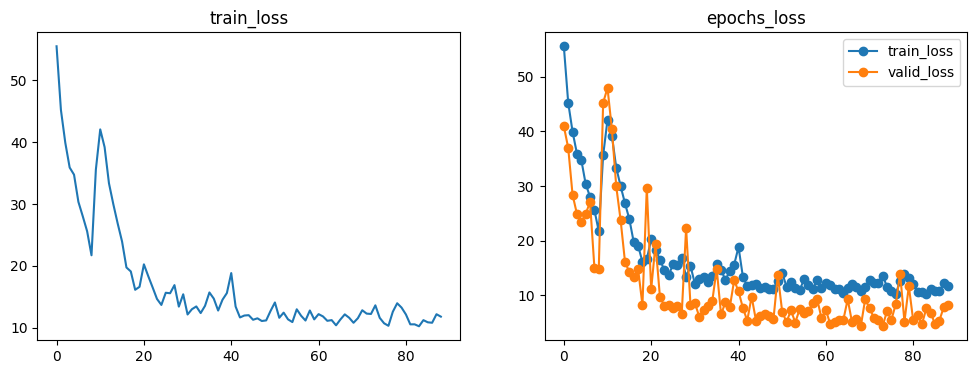

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_epochs_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss, '-o', label="train_loss")
plt.plot(valid_epochs_loss, '-o', label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.show()

# Tester

In [10]:
def tester(final=True):
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)

    print("Selecting features...")
    x_train, _, x_test, _, _ = select_feat(train_data, valid_data, test_data, select_all=False)

    test_dataset = COVID19Dataset(x_test)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    if final:
        model.load_state_dict(torch.load(model_final_path))
        print("***********- ***********- Using Final Model -*************")
    else:
        model.load_state_dict(torch.load(model_best_path))
        print("***********- ***********- Using Best Model -*************")

    print("***********- ***********- Test begin -*************")
    preds = []
    model.eval()
    # =========================test=======================
    for idx, (X) in enumerate(tqdm(test_dataloader)):
        if (len(args.gpus) > 0):
            X = X.cuda()
        with torch.no_grad():
            outputs = model(X)
            preds.append(outputs.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()

    print("***********- ***********- Save predictions -*************")
    save_file = args.submit_file
    with open(save_file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

    print("***********- ***********- Test finished -*************")

# Testing

In [11]:
tester(final=True)

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
Selecting features...
***********- ***********- Loading model -*************
***********- ***********- Using Single GPU -*************
***********- ***********- Using Final Model -*************
***********- ***********- Test begin -*************


100%|██████████| 5/5 [00:00<00:00, 15.65it/s]

***********- ***********- Save predictions -*************
***********- ***********- Test finished -*************
